In [1]:

import pandas as pd
def map_variable(
    val_or_series,
    mapping = None,
    nulls = None,
    keep = None,
    type_check = int
):
    # Deal with int-as-str issue, although I think low_memory=False should prevent this
    if keep:
        keep += [str(v) for v in keep if isinstance(v, int)]
    if nulls:
        nulls += [str(v) for v in nulls if isinstance(v, int)]
    if mapping:
        for k in list(mapping.keys()):
            if isinstance(k, int):
                mapping[str(k)] = mapping[k]

    def map_val(val):
        if pd.isna(val) or val == " ":
            return pd.NA
            #return None
        if nulls is not None and val in nulls:
            return pd.NA
            #return None
        elif keep is not None:
            if val in keep:
                return type_check(val)
            else:
                return pd.NA
                #return None
        elif mapping is not None:
            if val in mapping:
                return type_check(mapping[val])
            else:
                if nulls is not None: # assume that if we provided explicit nulls, nothing *else* maps to null
                    return type_check(val)
                else:
                    return pd.NA # otherwise, everything else maps to null; pass nulls = {} to avoid this
                    #return None
        else:
            return type_check(val)
        
    if isinstance(val_or_series, pd.Series):
        return val_or_series.apply(map_val)
    else:
        return map_val(val_or_series)
    

def validate_variable(df_var, values=None, min=None, max=None):
    distinct_values = df_var.dropna().unique()
    if len(distinct_values) == 0:
        raise ValueError("No non-missing values to validate in variable!")
    for val in distinct_values:
        if values is not None:
            if val not in values:
                raise ValueError(f"Value {val} not in allowed set of {values}")
        if min is not None:
            if val < min:
                raise ValueError(f"Value {val} less than minimum of {min}")
        if max is not None:
            if val > max:
                raise ValueError(f"Value {val} greater than maximum of {max}")
    return True

def json_to_kwargs(var, json_dict):
    kwargs = json_dict.copy()
    type_check = kwargs.pop("_type_", "int")
    if type_check == "int":
        type_check = int
    elif type_check == "float":
        type_check = float
    elif type_check == "str":
        type_check = str
    else:
        raise ValueError(f"Unsupported type {type_check} for variable {var}")
    kwargs["type_check"] = type_check
    if "mapping" in kwargs:
        mapping = {}
        for k, v in kwargs["mapping"].items():
            mapping[k] = v
            try:
                k2 = int(k)
                mapping[k2] = v
            except ValueError:
                pass
        kwargs["mapping"] = mapping
    kwargs = {k: v for k, v in kwargs.items() if not k.startswith("_")}
    return kwargs


In [2]:
calculations = {
    "white_black_diff": lambda row: (row["therm_whites"] - row["therm_blacks"]),
    "white_hisp_diff": lambda row: (row["therm_whites"] - row["therm_hisp"]),
    "age_group": lambda row: (
        pd.NA if pd.isna(row["age"]) else
        "18-29" if 18 <= int(row["age"]) <= 29 else
        "30-44" if 30 <= int(row["age"]) <= 44 else
        "45-64" if 45 <= int(row["age"]) <= 64 else
        "65+" if int(row["age"]) >= 65 else
        pd.NA
    ),
    "resentment": lambda row: (
        pd.NA if pd.isna(row["special_favors_minus"]) or pd.isna(row["tried_harder_minus"]) or pd.isna(row["past_slavery_plus"]) or pd.isna(row["less_deserve_plus"]) else
        int(row["past_slavery_plus"]) + int(row["less_deserve_plus"]) - int(row["special_favors_minus"]) - int(row["tried_harder_minus"])#+ 12 # if you want a 4-20 scale.
    ),
    "race_edu_block": lambda row: (
        pd.NA if pd.isna(row["college_3"]) or pd.isna(row["race"]) else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        "WhiteCollege" if row["race"] == "White" and row["college_3"] == 2 else
        "WhiteNonCollege" if row["race"] == "White" and row["college_3"] in (0,1) else
        pd.NA
    ),
    "race_party_block": lambda row: (
        pd.NA if pd.isna(row["race"]) or pd.isna(row["party_7"]) else
        "WhiteRep" if row["race"] == "White" and row["party_7"] in (6,7) else
        "WhiteDem" if row["race"] == "White" and row["party_7"] in (1,2) else
        "WhiteInd" if row["race"] == "White" else
        "NonWhite" if row["race"] in ("Black","Hispanic","Other") else
        pd.NA
    ),
    "race_party_6": lambda row: (
        pd.NA if pd.isna(row["race"]) or pd.isna(row["party_7"]) else
        "WhiteRep" if row["race"] == "White" and row["party_7"] in (6,7) else
        "WhiteDem" if row["race"] == "White" and row["party_7"] in (1,2) else
        "WhiteInd" if row["race"] == "White" else
        "Black" if row["race"] == "Black" else
        "Hispanic" if row["race"] == "Hispanic" else
        "Other" if row["race"] == "Other" else
        pd.NA
    ),
    "vote_prev_vote": lambda row: (
        pd.NA if pd.isna(row["prev_rep_pres"]) or pd.isna(row["vote_rep_pres"]) else
        "Rep-Rep" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 1 else
        "Rep-Dem" if row["prev_rep_pres"] == 1 and row["vote_rep_pres"] == 0 else
        "Dem-Rep" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 1 else
        "Dem-Dem" if row["prev_rep_pres"] == 0 and row["vote_rep_pres"] == 0 else
        pd.NA
    ),
    "republican": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] in (6,7) else 0
    ),
    "strong_republican": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] == 7 else 0
    ),
    "lean_republican": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] in (5,6,7) else 0
    ),
    "independent": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] in (3,4,5) else 0
    ),
    "democrat": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] in (1,2) else 0
    ),
    "strong_democrat": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] == 1 else 0
    ),
    "lean_democrat": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        1 if row["party_7"] in (1,2,3) else 0
    ),
    "party_3": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] in (1,2) else
        "R" if row["party_7"] in (6,7) else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "party_3_strong": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] == 1 else
        "R" if row["party_7"] == 7 else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "party_3_lean": lambda row: (
        pd.NA if pd.isna(row["party_7"]) else
        "D" if row["party_7"] == 1 else
        "R" if row["party_7"] == 7 else
        "I" if row["party_7"] in (2,3,4,5,6) else
        pd.NA
    ),
    "self_dem_diff": lambda row: (
        pd.NA if pd.isna(row["self_assist_blacks"]) or pd.isna(row["dem_assist_blacks"]) else
        row["dem_assist_blacks"] - row["self_assist_blacks"]
    ),
    "self_rep_diff": lambda row: (
        pd.NA if pd.isna(row["self_assist_blacks"]) or pd.isna(row["rep_assist_blacks"]) else
        row["rep_assist_blacks"] - row["self_assist_blacks"]
    ),
    "police_blacks_better_7": lambda row: (
        #pd.NA if "police_blacks_better_3" not in row or "police_blacks_better_degree" not in row else
        #pd.NA if "police_blacks_better_3" not in row.columns or pd.isna(row["police_blacks_better_degree"]) else
        #99 if not pd.isna(row["police_blacks_better_7"]) else
        row["police_blacks_better_7"] if "police_blacks_better_7" in row else
        pd.NA if pd.isna(row["police_blacks_better_3"]) else
        4 if row["police_blacks_better_3"] == 2 else
        pd.NA if pd.isna(row["police_blacks_better_degree"]) else
        4 - row["police_blacks_better_degree"] if row["police_blacks_better_3"] == 1 else
        4 + row["police_blacks_better_degree"] if row["police_blacks_better_3"] == 3 else
        pd.NA
    )
}

In [15]:

import json
with open("configs/clean_config.json", "r") as f:
    config = json.load(f)

config

{'2000': {'_file_': 'anes2000TS.dta',
  'caseid': 'V000001',
  'weight': {'_source_': 'V000002a', '_type_': 'float'},
  'age': {'_source_': 'V000908',
   'nulls': ['00. NA'],
   'mapping': {'97. 97 and older': 97},
   '_valid_': {'min': 0, 'max': 120}},
  'race': {'_source_': 'V001006a',
   'mapping': {'10. BLACK': 'Black',
    '20. ASIAN': 'Other',
    '30. NATIVE AMERICAN': 'Other',
    '40. HISPANIC OR LATINO': 'Hispanic',
    '50. WHITE': 'White',
    '60. OTHER SPECIFY - MISC.': 'Other',
    '75. OTHER SPECIFY - EAST INDIAN': 'Other',
    '75. OTHER SPECIFY - PACIFIC ISLANDER': 'Other',
    '79. OTHER SPECIFY - MORE THAN 3 MAJOR GR': 'Other',
    "80. OTHER SPECIFY - 'AMERICAN'": 'Other'},
   '_valid_': ['Black', 'White', 'Hispanic', 'Other'],
   '_type_': 'str'},
  'whites_influence': {'_source_': 'V001437',
   'mapping': {'1. TOO MUCH INFLUENCE': 1,
    '2. JUST ABOUT THE RIGHT AMOUNT': 2,
    '3. TOO LITTLE INFLUENCE': 3},
   '_valid_': [1, 2, 3]},
  'blacks_influence': {'_sour

In [17]:
import pandas as pd
import os

def build_dataframe(
        year=None,
        vars=None,
        config=None,
        datapath="data",
        return_raw=False,
        drop_weightless=True,
        calculated=[],
        calculations=None
):
    # fall back on default config
    if config is None:
        with open("configs/clean_config.json", "r") as f:
            config = json.load(f)
    # Need to specify year
    year_config = config.get(str(year), None)
    if year_config is None:
        raise ValueError(f"No configuration found for year {year}")
    # Use all vars for the year if none specified
    vars =  [var for var in year_config.keys() if not var.startswith("_")] if vars is None else vars
    fname = year_config["_file_"]
    if fname.endswith(".dta"):
        raw = pd.read_stata(os.path.join(datapath, fname))
    elif fname.endswith(".csv"):
        raw = pd.read_csv(os.path.join(datapath, fname), low_memory=False)
    # early exit for development
    if return_raw:
        return raw
    # build dataframe
    df = raw[[]].copy()
    df["year"] = year
    for var in vars:
        if var not in year_config:
            continue # this is allowed
        var_config = year_config[var]
        if not var_config:
            pass # skip variable if config is null/None/empty
        elif isinstance(var_config, str):
            df[var] = raw[var_config]
            #df[var] = map_variable(raw[var_config])
        elif isinstance(var_config, dict):
            source = var_config.get("_source_", None)
            kwargs = json_to_kwargs(var, var_config)
            df[var] = map_variable(raw[source], **kwargs)
            # validate if desired
            if "_valid_" in var_config:
                valid = var_config["_valid_"]
                if isinstance(valid, list):
                    validate_variable(df[var], values=valid)
                else:
                    validate_variable(df[var], **valid)
    ## Worry about calculated variables later
    pass
    # drop rows with missing weights if desired
    if drop_weightless and "weight" in df.columns:
        df = df[~df["weight"].isna()]
    # add calculated variables if desired
    if calculated:
        for var in calculated:
            if var not in calculations:
                raise ValueError(f"No calculation found for variable {var}")
            try:
                df[var] = df.apply(calculations[var], axis=1)
            except KeyError as e:
                pass
            except Exception as e:
                print(f"Error calculating variable {var}:")
                raise e
    # return dataframe
    return df


def build_dataframes(
    years=[2000, 2004, 2008, 2012, 2016, 2020, 2024],
    vars=None,
    config=None,
    datapath="data",
    calculated=[],
    calculations=None
):
    # fall back on default config
    if config is None:
        with open("configs/clean_config.json", "r") as f:
            config = json.load(f)
    # get yearly data
    dfs = []
    for year in years:
        print(year)
        df = build_dataframe(
            year=year,
            vars=vars,
            config=config,
            datapath=datapath,
            calculated=calculated,
            calculations=calculations
        )
        dfs.append(df)
    # concatenate all dataframes
    df_all = pd.concat(dfs, ignore_index=True).convert_dtypes(dtype_backend="numpy_nullable")
    return df_all

In [1]:
var = "V165723"
year = 2016
test = build_dataframe(year=year,vars = [var], return_raw=True)
test[var].value_counts(dropna=False).sort_index() # Is there some way of dealing with this?
# Ugh, this is one of those "no summary variable" situations.  So, the 

NameError: name 'build_dataframe' is not defined

In [7]:
var = "race"
year = 2012
test = build_dataframes(
    years = [year],
    vars = [var]
)
test[var].value_counts(dropna=False).sort_index()

2012


race
Black       1021
Hispanic    1009
Other        126
White       3509
<NA>         249
Name: count, dtype: Int64

In [19]:
anes = build_dataframes(
    vars = [
        "caseid",
        "weight",
        "age",
        "race",
        "whites_influence",
        "blacks_influence",
        "hispanics_influence",
        "party_7",
        "less_immig",
        "college_3",
        "therm_hisp",
        "therm_blacks",
        "therm_whites",
        "self_assist_blacks",
        "dem_assist_blacks",
        "rep_assist_blacks",
        "special_favors_minus",
        "past_slavery_plus",
        "less_deserve_plus",
        "tried_harder_minus",
        "vote_rep_pres",
        "prev_rep_pres",
        "blacks_hardworking",
        "blacks_hiring",
        "therm_illegal",
        "police_blacks_better_3",
        "police_blacks_better_degree",
        "police_blacks_better_7",
        "therm_police",
        "therm_trans",
        "trans_bath",
        "immig_crime",
        "women_favors",
        "women_problems"

    ],
    calculated=[
        "party_3",
        "party_3_strong",
        "party_3_lean",
        "resentment",
        "race_edu_block",
        "race_party_block",
        "self_dem_diff",
        "self_rep_diff",
        "self_rep_diff",
        "white_black_diff",
        "white_hisp_diff",
        "vote_prev_vote",
        "republican",
        "democrat",
        "strong_republican",
        "lean_republican",
        "independent",
        "strong_democrat",
        "lean_democrat",
        "race_party_6",
        "police_blacks_better_7"
    ],
    calculations=calculations
)
for year in [2000, 2004, 2008, 2012, 2016, 2020, 2024]:
    dta = anes[anes["year"] == year]
    print(year)
    print(dta["resentment"].value_counts(dropna=False).sort_index())


whites = anes[anes["race"] == "White"]

2000
2004
2008
2012
2016


/tmp/ipykernel_2654894/3501580055.py:26: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  raw = pd.read_stata(os.path.join(datapath, fname))


2020
2024
2000
resentment
-8       22
-7       13
-6       18
-5       41
-4       73
-3       55
-2       99
-1       86
0       185
1       134
2       139
3       125
4       128
5       120
6        80
7        92
8       104
<NA>    293
Name: count, dtype: Int64
2004
resentment
-8       26
-7       15
-6       26
-5       22
-4       45
-3       47
-2       64
-1       65
0       108
1        90
2        99
3        84
4       108
5        82
6        52
7        49
8        64
<NA>    166
Name: count, dtype: Int64
2008
resentment
-8       26
-7       25
-6       31
-5       54
-4       92
-3       81
-2       96
-1      144
0       248
1       246
2       215
3       174
4       164
5       140
6       101
7        91
8       131
<NA>     43
Name: count, dtype: Int64
2012
resentment
-8       85
-7       72
-6       89
-5      139
-4      222
-3      253
-2      303
-1      329
0       636
1       428
2       497
3       429
4       476
5       365
6       311
7       305
8       

In [21]:
anes["women_favors"].value_counts()

women_favors
4    7047
5    6804
2    4789
3    3812
1    1707
Name: count, dtype: Int64

In [ ]:
whites["trans_bath"].value_counts()

police_blacks_better_3
1    1360
2    1202
3      34
Name: count, dtype: Int64

In [24]:
whites["police_blacks_better_7"].value_counts()

police_blacks_better_7
4    4463
1    2824
2    2338
3    1489
6      61
5      46
7      40
Name: count, dtype: Int64

In [25]:
## Compute weighted mean
import matplotlib.pyplot as plt
def weighted_mean(data, val_col, weight="weight"):
    #print(type(data))
    nomiss = data[data[val_col].notna() & data[weight].notna()]
    if len(nomiss) == 0:
        raise ValueError("No valid data to compute weighted mean")
    return (nomiss[val_col] * nomiss[weight]).sum() / nomiss[weight].sum()


## Plot a weighted aggregate function of a variable over time, usually weighted mean, optional grouping
def plot_weight_agg_over_time(
    df,
    var,
    weight = "weight",
    time = "year",
    title = None,
    groupby = None,
    agg = weighted_mean,
):
    nomiss = df[df[var].notna() & df[weight].notna()]
    if groupby is not None:
        for g in groupby:
            nomiss = nomiss[nomiss[g].notna()]
    if len(nomiss) == 0:
        raise ValueError("No valid data to plot")
    
    if groupby is not None:
        nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()
    else:
        nomiss.groupby(time).apply(agg, var, weight=weight).plot()

    if title is None:
        title = f"Average {var} by {time}"
    plt.title(title)
    plt.xticks(df[time].unique())
    plt.show()

/tmp/ipykernel_1100798/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


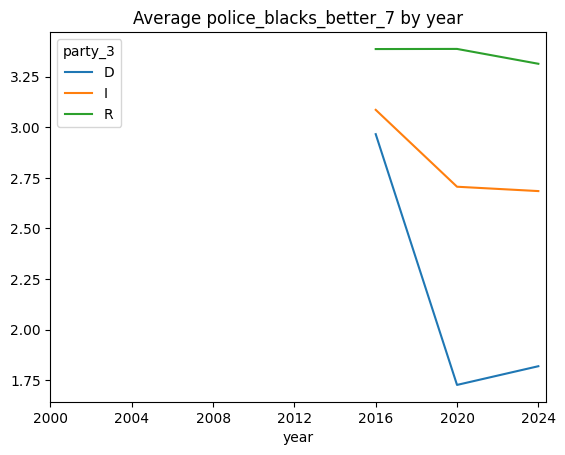

In [26]:
plot_weight_agg_over_time(whites, "police_blacks_better_7", groupby=["party_3"])

/tmp/ipykernel_1100798/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


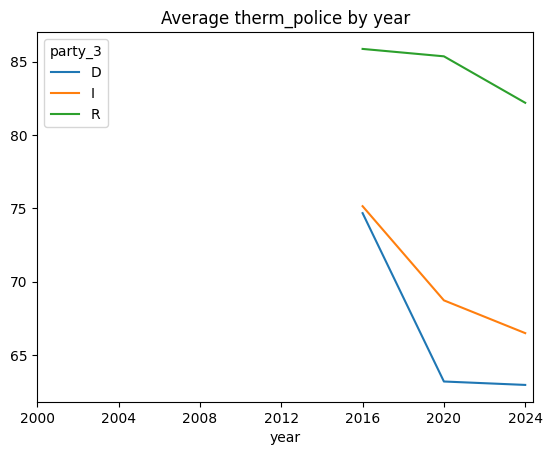

In [42]:
plot_weight_agg_over_time(whites, "therm_police", groupby=["party_3"])

/tmp/ipykernel_1100798/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


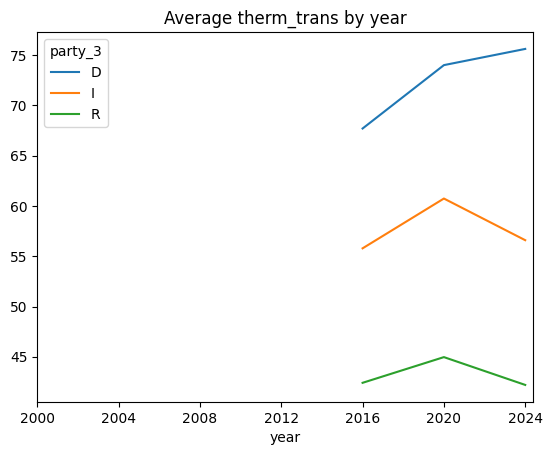

In [43]:
plot_weight_agg_over_time(whites, "therm_trans", groupby=["party_3"])

/tmp/ipykernel_1100798/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


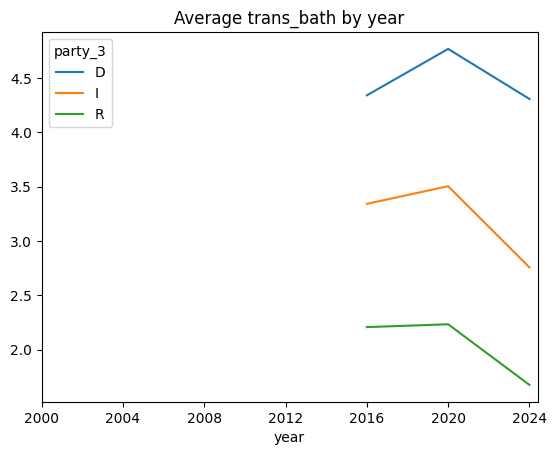

In [49]:
plot_weight_agg_over_time(whites, "trans_bath", groupby=["party_3"])

/tmp/ipykernel_1100798/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


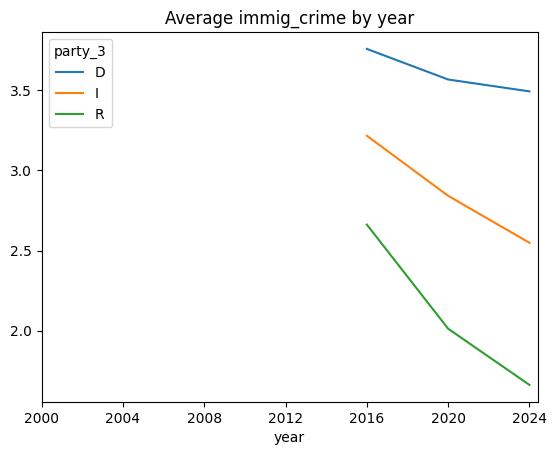

In [50]:
plot_weight_agg_over_time(whites, "immig_crime", groupby=["party_3"])

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


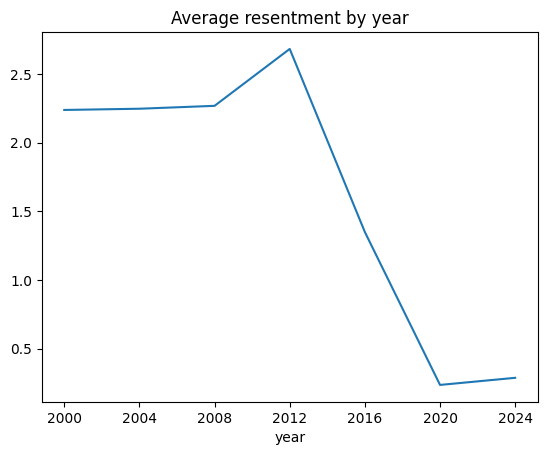

In [11]:
plot_weight_agg_over_time(whites, "resentment")

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


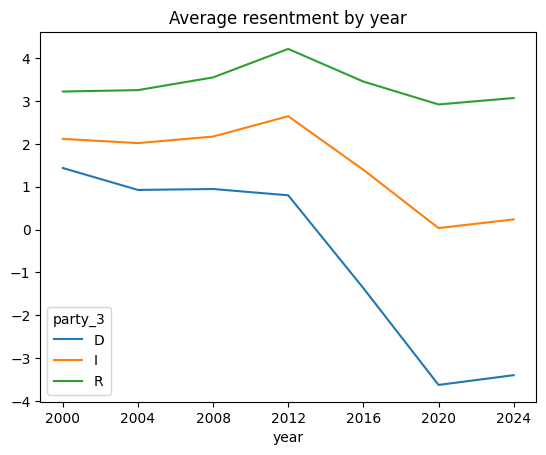

In [12]:
plot_weight_agg_over_time(whites, "resentment", groupby=["party_3"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


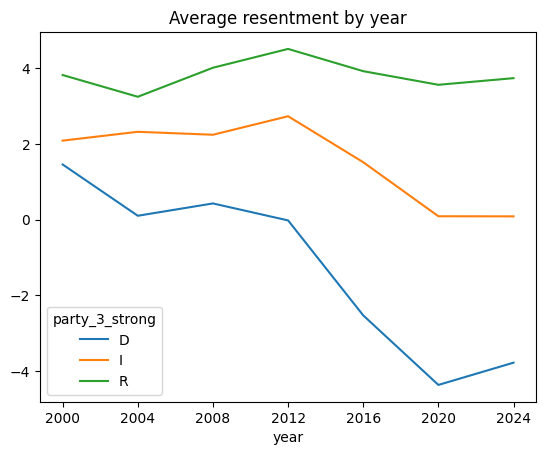

In [13]:
plot_weight_agg_over_time(whites, "resentment", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


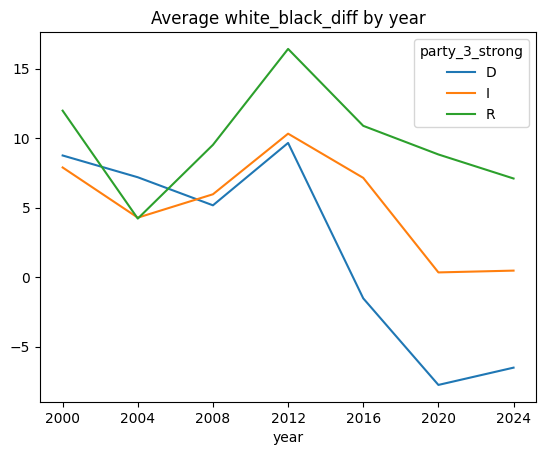

In [14]:
plot_weight_agg_over_time(whites, "white_black_diff", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


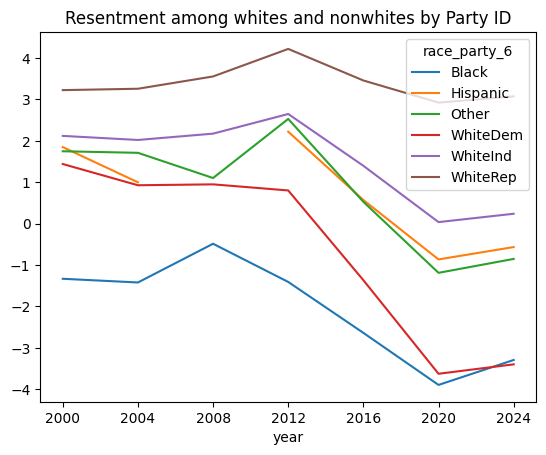

In [15]:
plot_weight_agg_over_time(anes, "resentment", groupby=["race_party_6"], title="Resentment among whites and nonwhites by Party ID")

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


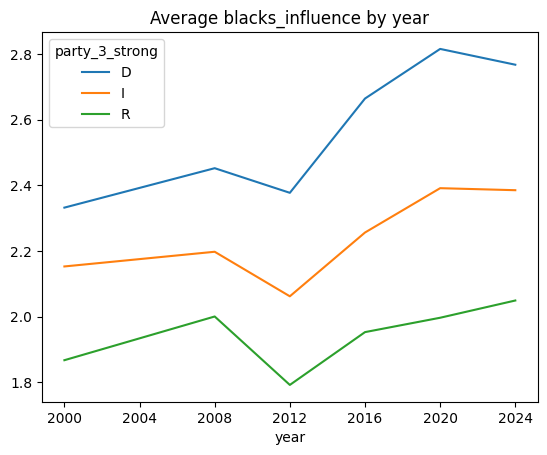

In [16]:
plot_weight_agg_over_time(whites, "blacks_influence", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


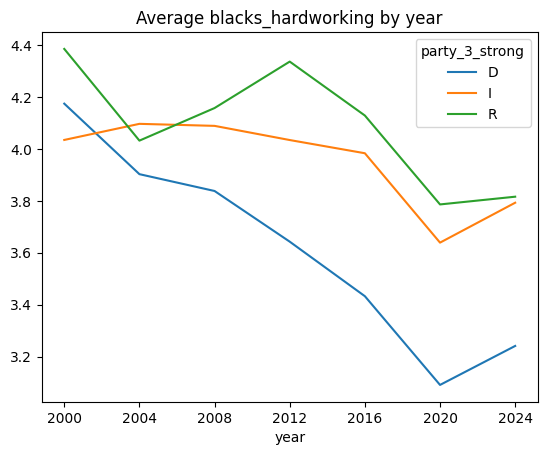

In [17]:
plot_weight_agg_over_time(whites, "blacks_hardworking", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


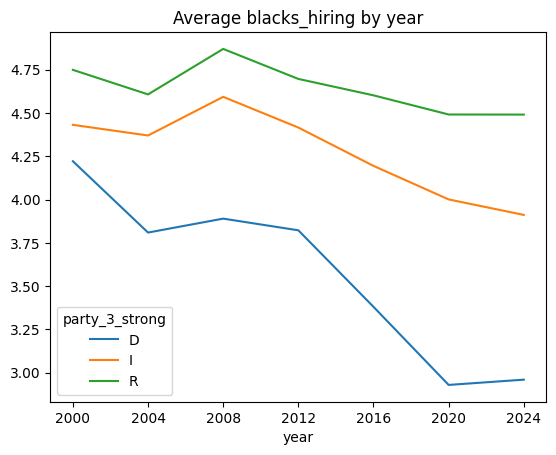

In [18]:
plot_weight_agg_over_time(whites, "blacks_hiring", groupby=["party_3_strong"]) # 2008 item is a little wonky for this one

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


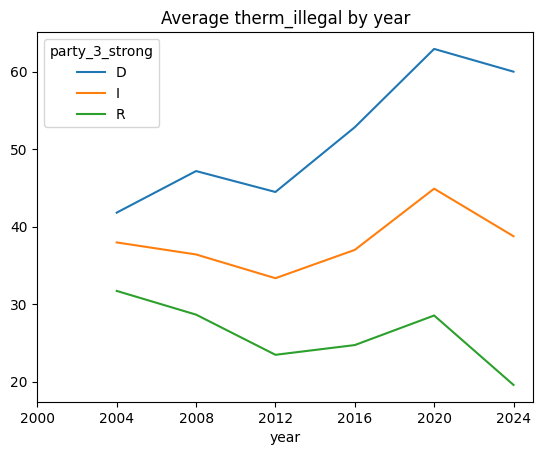

In [19]:
plot_weight_agg_over_time(whites, "therm_illegal", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


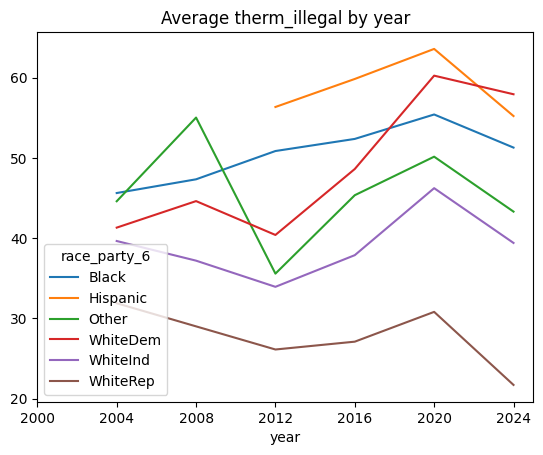

In [20]:
plot_weight_agg_over_time(anes, "therm_illegal", groupby=["race_party_6"])

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


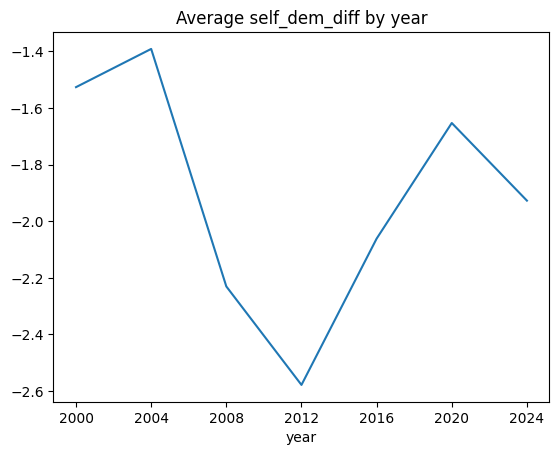

In [21]:
plot_weight_agg_over_time(whites, "self_dem_diff")

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


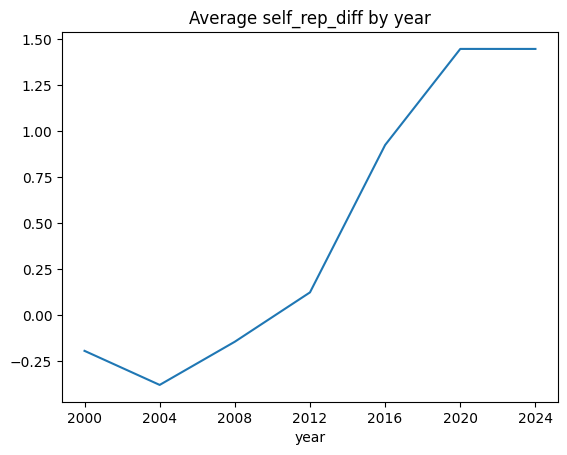

In [22]:
plot_weight_agg_over_time(whites, "self_rep_diff")

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


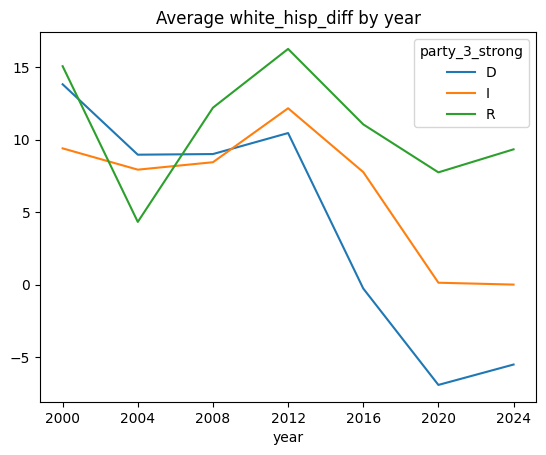

In [23]:
plot_weight_agg_over_time(whites, "white_hisp_diff", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


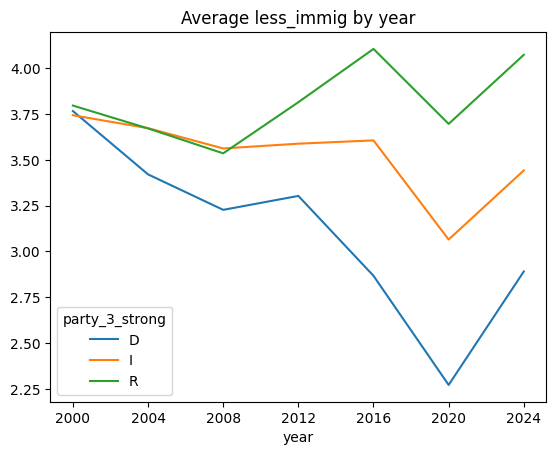

In [24]:
plot_weight_agg_over_time(whites, "less_immig", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


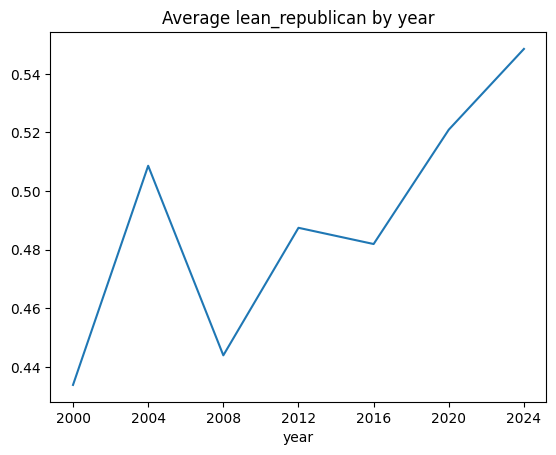

In [25]:
plot_weight_agg_over_time(whites, "lean_republican")

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


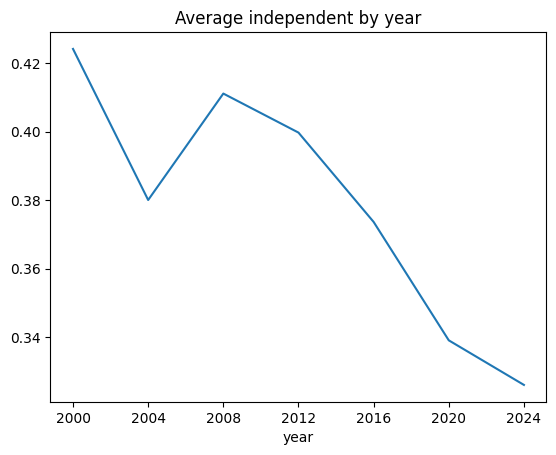

In [26]:
plot_weight_agg_over_time(whites, "independent")

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


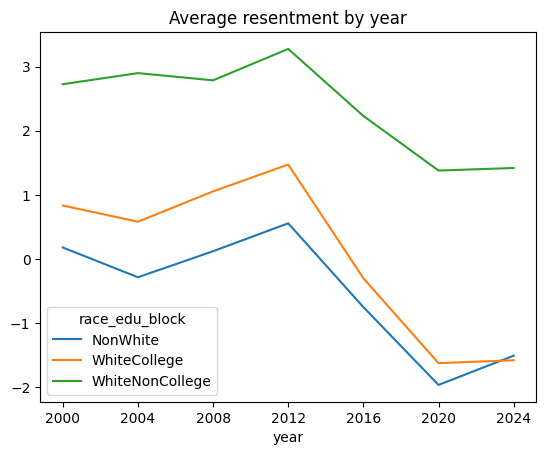

In [27]:
plot_weight_agg_over_time(anes, "resentment", groupby=["race_edu_block"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


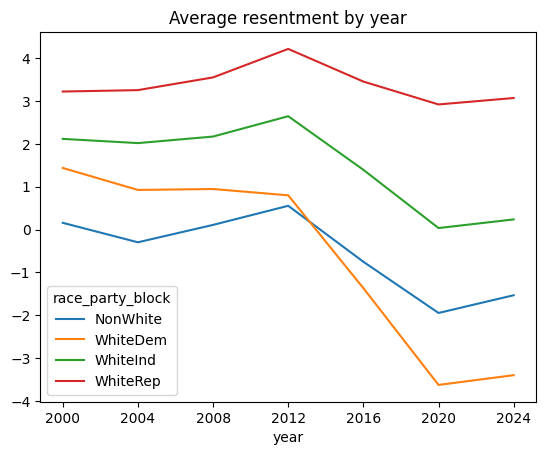

In [28]:
plot_weight_agg_over_time(anes, "resentment", groupby=["race_party_block"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


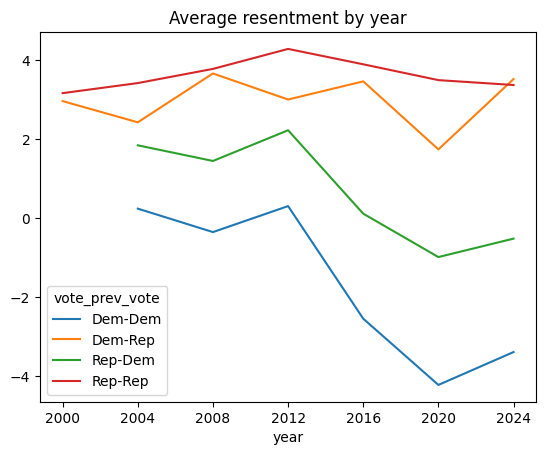

In [29]:
plot_weight_agg_over_time(whites, "resentment", groupby=["vote_prev_vote"])
# These are weird graphs because the meaning of the grouping is different every year; by definition it can't be the same people

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


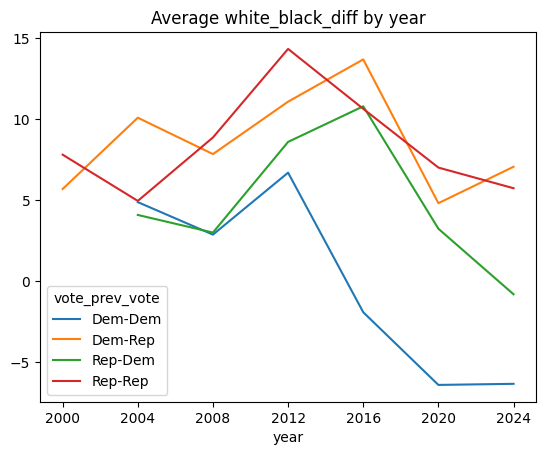

In [30]:
plot_weight_agg_over_time(whites, "white_black_diff", groupby=["vote_prev_vote"])

/tmp/ipykernel_553235/1552359890.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby([time] + groupby).apply(agg, var, weight=weight).unstack().plot()


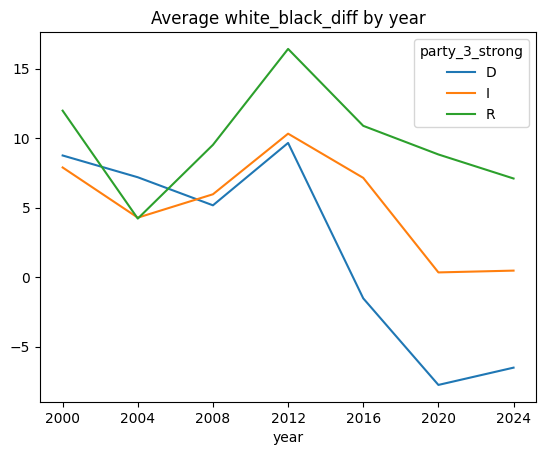

In [31]:
plot_weight_agg_over_time(whites, "white_black_diff", groupby=["party_3_strong"])

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


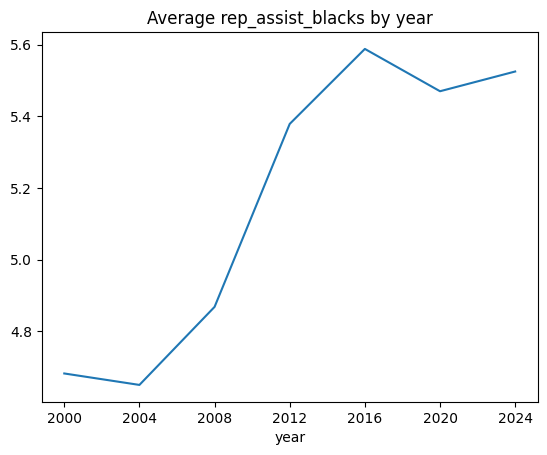

In [32]:
plot_weight_agg_over_time(whites, "rep_assist_blacks")

/tmp/ipykernel_553235/1552359890.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nomiss.groupby(time).apply(agg, var, weight=weight).plot()


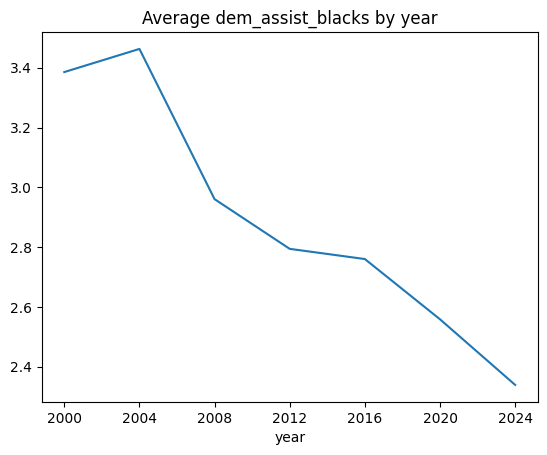

In [33]:
plot_weight_agg_over_time(whites, "dem_assist_blacks")

/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depreca

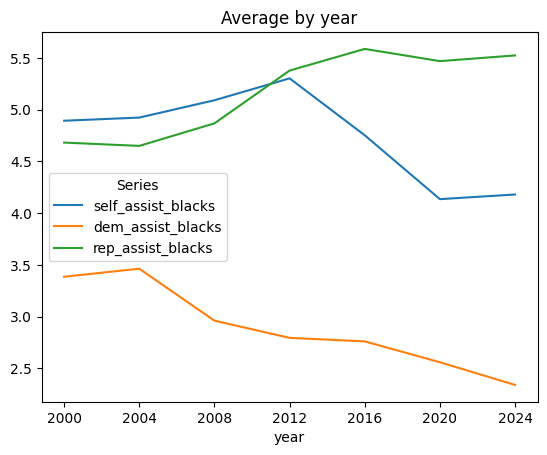

In [34]:
def plot_multiple_weight_agg_over_time(
    df,
    vars,
    weight="weight",
    time="year",
    title=None,
    groupby=None,
    agg=weighted_mean,
    legend_title="Series",
):
    fig, ax = plt.subplots()

    for var in vars:
        nomiss = df[df[var].notna() & df[weight].notna()]
        if groupby is not None:
            for g in groupby:
                nomiss = nomiss[nomiss[g].notna()]
        if len(nomiss) == 0:
            raise ValueError("No valid data to plot")

        if groupby is not None:
            dfp = (
                nomiss.groupby([time] + groupby)
                .apply(agg, var, weight=weight)
                .unstack()
            )
            # Make legend entries informative: "<var>: <group>"
            dfp = dfp.rename(columns=lambda c: f"{var}: {c}")
            dfp.plot(ax=ax)
        else:
            s = nomiss.groupby(time).apply(agg, var, weight=weight)
            s.name = var  # ensures legend entry
            s.plot(ax=ax)

    if title is None:
        title = f"Average by {time}"
    ax.set_title(title)
    ax.set_xticks(sorted(pd.Series(df[time]).dropna().unique()))
    ax.legend(title=legend_title)
    plt.show()

plot_multiple_weight_agg_over_time(whites, ["self_assist_blacks", "dem_assist_blacks", "rep_assist_blacks"])

/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depreca

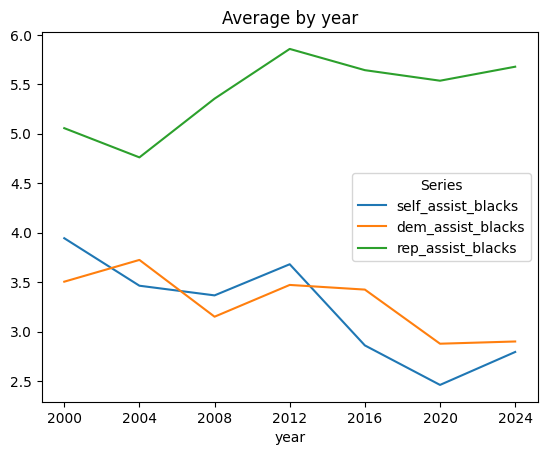

In [35]:
blacks = anes[anes["race"] == "Black"]
plot_multiple_weight_agg_over_time(blacks, ["self_assist_blacks", "dem_assist_blacks", "rep_assist_blacks"])

/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depreca

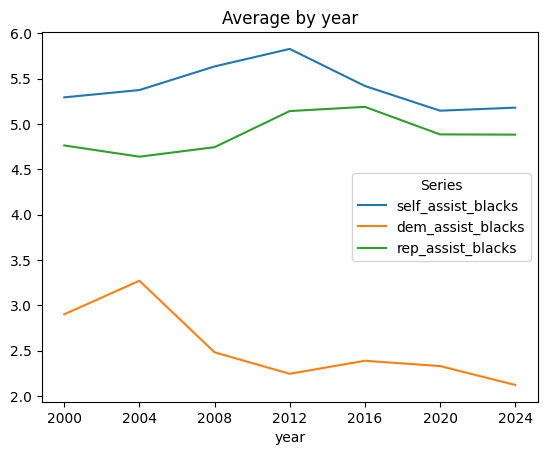

In [36]:
republican = anes[anes["party_3"] == "R"]
plot_multiple_weight_agg_over_time(republican, ["self_assist_blacks", "dem_assist_blacks", "rep_assist_blacks"])

/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depreca

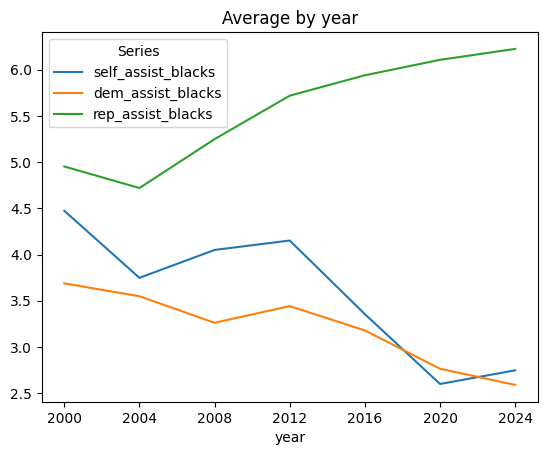

In [37]:
democrat = anes[anes["party_3"] == "D"]
plot_multiple_weight_agg_over_time(democrat, ["self_assist_blacks", "dem_assist_blacks", "rep_assist_blacks"])

/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  s = nomiss.groupby(time).apply(agg, var, weight=weight)
/tmp/ipykernel_553235/2226339311.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is depreca

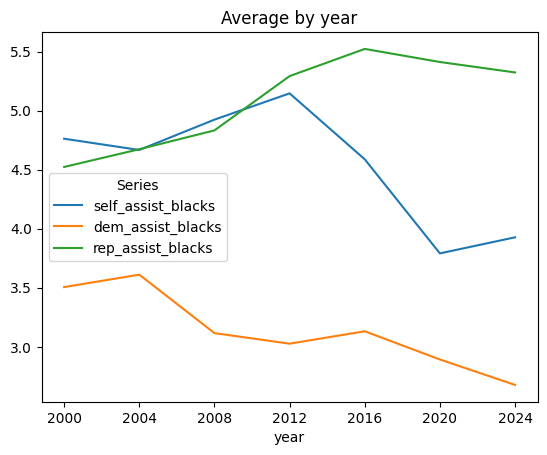

In [38]:
independent = anes[anes["party_3"] == "I"]
plot_multiple_weight_agg_over_time(independent, ["self_assist_blacks", "dem_assist_blacks", "rep_assist_blacks"])